## LangGraph agents
docs: https://langchain-ai.github.io/langgraph/

In [ ]:
#for graph drawing
import grandalf

## Create an agent

In [15]:
from langgraph.prebuilt import create_react_agent
from langchain_mistralai import ChatMistralAI
from pydantic import BaseModel

llm = ChatMistralAI(
    model="mistral-medium-latest",
    temperature=0,
    max_retries=2,
)

def get_weather(city: str) -> str:  
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"


agent = create_react_agent(
    #model="anthropic:claude-3-7-sonnet-latest",  
    model=llm,
    tools=[get_weather],  
    prompt="You are a helpful assistant",

)

# Run the agent
agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather in sf"}]}
)



{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='04874d7b-d5aa-4fbf-8519-97ac3422f713'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'iUC5ioMph', 'function': {'name': 'get_weather', 'arguments': '{"city": "San Francisco"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 76, 'total_tokens': 89, 'completion_tokens': 13}, 'model_name': 'mistral-medium-latest', 'model': 'mistral-medium-latest', 'finish_reason': 'tool_calls'}, id='run-73fc3465-d0bd-42e7-9e6c-2c257d4b9591-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'San Francisco'}, 'id': 'iUC5ioMph', 'type': 'tool_call'}], usage_metadata={'input_tokens': 76, 'output_tokens': 13, 'total_tokens': 89}),
  ToolMessage(content="It's always sunny in San Francisco!", name='get_weather', id='da603d87-6f71-4284-bd46-79661425bcbe', tool_call_id='iUC5ioMph'),
  AIMessage(content='Sunny', additional_kwargs={}, response_metadata={'token_

In [12]:
print(agent.get_graph().draw_ascii())

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +-------+           
          | agent |           
          +-------+.          
          .         .         
        ..           ..       
       .               .      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


In [17]:
# with memory
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()

agent = create_react_agent(
    model=llm,
    tools=[get_weather],
    checkpointer=checkpointer  
)

# Run the agent
config = {"configurable": {"thread_id": "1"}}
sf_response = agent.invoke(
    {"messages": [{"role": "user", "content": "what is the weather in sf"}]},
    config  
)
ny_response = agent.invoke(
    {"messages": [{"role": "user", "content": "what about new york?"}]},
    config
)

In [18]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt
from langgraph.prebuilt import create_react_agent

# An example of a sensitive tool that requires human review / approval
def book_hotel(hotel_name: str):
    """Book a hotel"""
    response = interrupt(  
        f"Trying to call `book_hotel` with args {{'hotel_name': {hotel_name}}}. "
        "Please approve or suggest edits."
    )
    if response["type"] == "accept":
        pass
    elif response["type"] == "edit":
        hotel_name = response["args"]["hotel_name"]
    else:
        raise ValueError(f"Unknown response type: {response['type']}")
    return f"Successfully booked a stay at {hotel_name}."

checkpointer = InMemorySaver() 

agent = create_react_agent(
    model="anthropic:claude-3-5-sonnet-latest",
    tools=[book_hotel],
    checkpointer=checkpointer, 
)

config = {
   "configurable": {
      "thread_id": "1"
   }
}

for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "book a stay at McKittrick hotel"}]},
    config
):
    print(chunk)
    print("\n")

{'agent': {'messages': [AIMessage(content=[{'text': "I'll help you book a stay at the McKittrick Hotel.", 'type': 'text'}, {'id': 'toolu_012LMJJSD1ZP5zYrbgAekonD', 'input': {'hotel_name': 'McKittrick'}, 'name': 'book_hotel', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01NdxCfnZ32cPKf8TAfz7Ypk', 'model': 'claude-3-5-sonnet-latest', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 383, 'output_tokens': 72}, 'model_name': 'claude-3-5-sonnet-latest'}, id='run-0e0dce07-67a6-43f9-8d30-722f0565d60e-0', tool_calls=[{'name': 'book_hotel', 'args': {'hotel_name': 'McKittrick'}, 'id': 'toolu_012LMJJSD1ZP5zYrbgAekonD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 383, 'output_tokens': 72, 'total_tokens': 455, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})]}}


{'__interrupt__': (Interrupt(value="Trying to call `book_hotel` with args {'hotel_name': McKit

In [4]:
from langchain_mistralai import ChatMistralAI
from pydantic import BaseModel

llm = ChatMistralAI(
    model="mistral-medium-latest",
    temperature=0,
    max_retries=2,
)

# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3? Use the tool call to calculate it.")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'jlj41G30O',
  'type': 'tool_call'}]

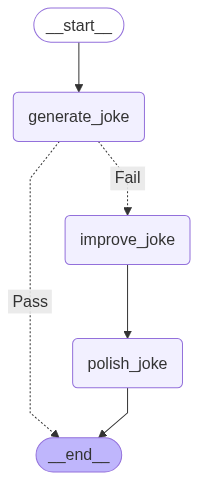

Retrying langchain_mistralai.chat_models.ChatMistralAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised ReadTimeout: The read operation timed out.


In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")
